In [25]:
import pandas as pd
import os
import numpy as np
import shutil
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import seaborn_image as isns
import cv2
import albumentations
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

In [2]:
data = pd.read_csv("../fashion/styles.csv", error_bad_lines=False, index_col=False)
data = data.dropna()
data

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


In [3]:
imageFiles = os.listdir("../fashion/images")
print("Number of image files: {}".format(len(imageFiles)))

Number of image files: 44072


In [4]:
try:
    os.mkdir("../fashion/not_available")
except:
    pass
imageIds = [file[:-4] for file in imageFiles]
for idx in tqdm(imageIds):
    if int(idx) not in data.id.tolist():
        shutil.move("../fashion/images/{}.jpg".format(idx), "../fashion/not_available/{}.jpg".format(idx))

In [5]:
columns_to_trim = ['masterCategory', 'subCategory']
thresholds = dict()
for col in columns_to_trim:
    print("Threshold for {}: {}".format(col, data[col].value_counts().median()))
    thresholds[col] = data[col].value_counts().median()

Threshold for masterCategory: 2139.0
Threshold for subCategory: 129.0


In [6]:
for col in columns_to_trim:
    try:
        filteredData = filteredData.groupby(col).filter(lambda x: len(x) > thresholds[col])
    except:
        filteredData = data.groupby(col).filter(lambda x: len(x) > thresholds[col])

filteredData

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44418,42234,Women,Apparel,Topwear,Tops,Blue,Summer,2012.0,Casual,Sepia Women Blue Printed Top
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt


In [7]:
print("{} Genders: {}\n".format(len(filteredData.gender.unique()), filteredData.gender.unique()))
print("{} Master Categories: {}\n".format(len(filteredData.masterCategory.unique()), filteredData.masterCategory.unique()))
print("{} Sub Categories: {}\n".format(len(filteredData.subCategory.unique()), filteredData.subCategory.unique()))

5 Genders: ['Men' 'Women' 'Boys' 'Girls' 'Unisex']

3 Master Categories: ['Apparel' 'Accessories' 'Footwear']

18 Sub Categories: ['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Jewellery' 'Saree' 'Eyewear' 'Dress'
 'Loungewear and Nightwear' 'Wallets' 'Headwear' 'Ties']



<AxesSubplot:>

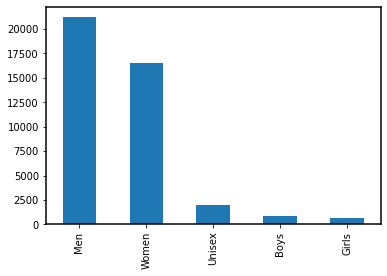

In [8]:
pd.DataFrame(filteredData.gender.value_counts())['gender'].plot(kind='bar')

<AxesSubplot:>

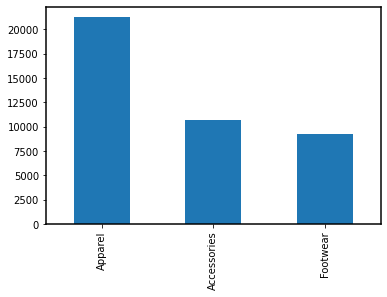

In [9]:
pd.DataFrame(filteredData.masterCategory.value_counts())['masterCategory'].plot(kind='bar')

<AxesSubplot:>

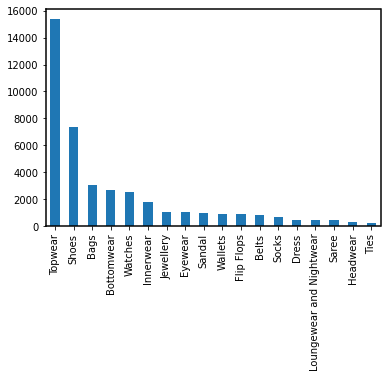

In [10]:
pd.DataFrame(filteredData.subCategory.value_counts())['subCategory'].plot(kind='bar')

In [65]:
sampleId = random.choice(filteredData.id)
sampleId

36998

In [66]:
sample = "../fashion/images/{}.jpg".format(sampleId)
sample

'../fashion/images/36998.jpg'

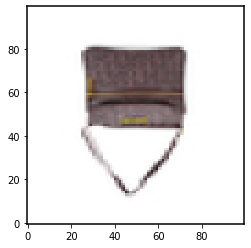

In [67]:
image = cv2.imread(sample)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (100, 100), interpolation = cv2.INTER_AREA)
plt.imshow(image)
plt.show()

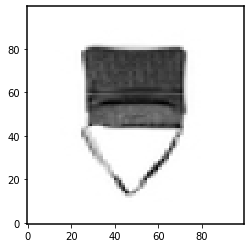

In [68]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

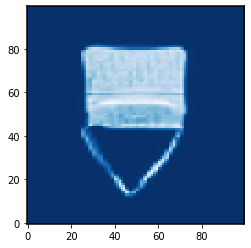

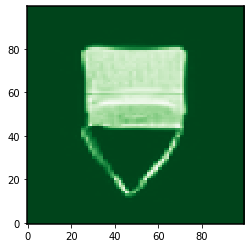

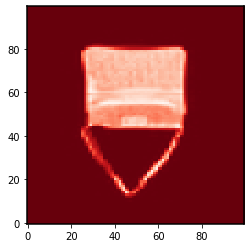

In [69]:
blue, green, red = cv2.split(image)
plt.imshow(blue, cmap='Blues')
plt.show()
plt.imshow(green, cmap='Greens')
plt.show()
plt.imshow(red, cmap='Reds')
plt.show()

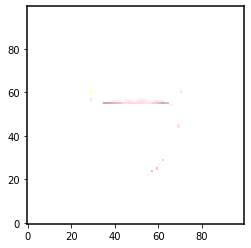

In [70]:
adjusted_image = np.zeros(image.shape, image.dtype)
alpha = 3.0
beta = 100
adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
#cv2.imshow("Image", adjusted_image)
plt.imshow(adjusted_image)
plt.show()
#cv2.waitKey(0)
#cv2.destroyAllWindows()

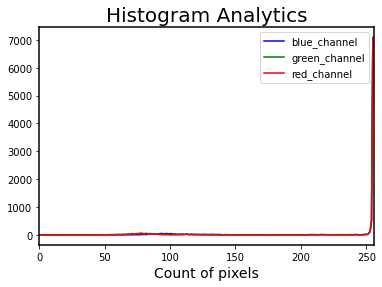

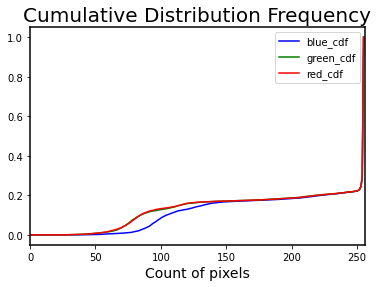

In [71]:
colors = ['blue', 'green', 'red']
for i, color in enumerate(colors):
    histogram = cv2.calcHist([image], [i], None, [256], [0, 256])
    cdf = histogram.cumsum()
    cdf_percent = cdf/cdf.max()
    plt.plot(histogram, color=color, label=color+'_channel')
    plt.xlim([0,256])
    
plt.title("Histogram Analytics", fontsize=20)
plt.xlabel('Range of intensity values', fontsize=14)
plt.xlabel('Count of pixels', fontsize=14)
plt.legend()
plt.show()

for i, color in enumerate(colors):
    histogram = cv2.calcHist([image], [i], None, [256], [0, 256])
    cdf = histogram.cumsum()
    cdf_percent = cdf/cdf.max()
    plt.plot(cdf_percent, color=color, label=color+'_cdf')
    plt.xlim([0,256])
    
plt.title("Cumulative Distribution Frequency", fontsize=20)
plt.xlabel('Range of intensity values', fontsize=14)
plt.xlabel('Count of pixels', fontsize=14)
plt.legend()
plt.show()

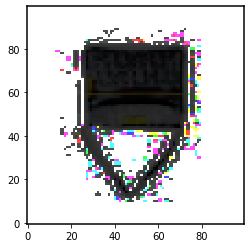

In [72]:
hist_blue = cv2.calcHist([blue], [0], None, [256], [0, 256])
hist_green = cv2.calcHist([green], [0], None, [256], [0, 256])
hist_red = cv2.calcHist([red], [0], None, [256], [0, 256])

cdf_blue = hist_blue.cumsum()
cdf_green = hist_green.cumsum()
cdf_red = hist_red.cumsum()

cdf_blue_masked = np.ma.masked_equal(cdf_blue, 0)
cdf_green_masked = np.ma.masked_equal(cdf_green, 0)
cdf_red_masked = np.ma.masked_equal(cdf_red, 0)

cdf_blue_masked = (cdf_blue_masked - cdf_blue_masked.min())*255 / (cdf_blue_masked.max() - cdf_blue_masked.min())
cdf_green_masked = (cdf_green_masked - cdf_green_masked.min())*255 / (cdf_green_masked.max() - cdf_green_masked.min())
cdf_red_masked = (cdf_red_masked - cdf_red_masked.min())*255 / (cdf_red_masked.max() - cdf_red_masked.min())

cdf_final_b = np.ma.filled(cdf_blue_masked, 0).astype('uint8')
cdf_final_g = np.ma.filled(cdf_green_masked, 0).astype('uint8')
cdf_final_r = np.ma.filled(cdf_red_masked, 0).astype('uint8')

blue_img = cdf_final_b[blue]
green_img = cdf_final_g[green]
red_img = cdf_final_r[red]

final_equ_img = cv2.merge((blue_img, green_img, red_img))
plt.imshow(final_equ_img)
plt.show()

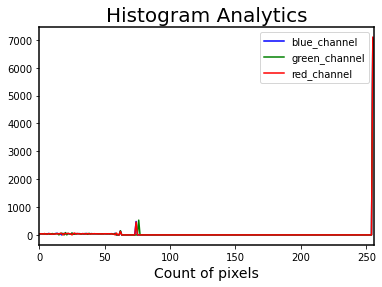

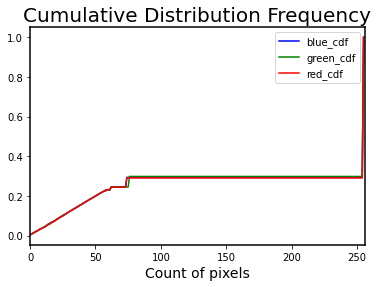

In [73]:
colors = ['blue', 'green', 'red']
for i, color in enumerate(colors):
    histogram = cv2.calcHist([final_equ_img], [i], None, [256], [0, 256])
    cdf = histogram.cumsum()
    cdf_percent = cdf/cdf.max()
    plt.plot(histogram, color=color, label=color+'_channel')
    plt.xlim([0,256])
    
plt.title("Histogram Analytics", fontsize=20)
plt.xlabel('Range of intensity values', fontsize=14)
plt.xlabel('Count of pixels', fontsize=14)
plt.legend()
plt.show()

for i, color in enumerate(colors):
    histogram = cv2.calcHist([final_equ_img], [i], None, [256], [0, 256])
    cdf = histogram.cumsum()
    cdf_percent = cdf/cdf.max()
    plt.plot(cdf_percent, color=color, label=color+'_cdf')
    plt.xlim([0,256])
    
plt.title("Cumulative Distribution Frequency", fontsize=20)
plt.xlabel('Range of intensity values', fontsize=14)
plt.xlabel('Count of pixels', fontsize=14)
plt.legend()
plt.show()

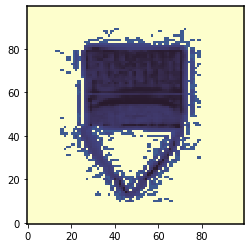

In [74]:
image = cv2.imread(sample)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (100, 100), interpolation = cv2.INTER_AREA)
image = cv2.equalizeHist(image)
plt.imshow(image)
plt.show()

In [75]:
class FashionDataset(Dataset):
    
    def __init__(self, file_paths, labels, transform=None):
        
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            aug = self.transform(image=image)
            image = aug['image']
        
        return image, label

In [76]:
transform = albumentations.Compose([
    albumentations.Resize(150, 150),
    albumentations.CenterCrop(100, 100),
    albumentations.OneOf([
        albumentations.HorizontalFlip(p=1),
        albumentations.RandomRotate90(p=1),
        albumentations.VerticalFlip(p=1)
    ], p=1),
    albumentations.OneOf([
        albumentations.MotionBlur(p=1),
        albumentations.OpticalDistortion(p=1),
        albumentations.GaussNoise(p=1)
    ], p=1),
    albumentations.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2()
])

In [77]:
dataset = FashionDataset(file_paths=[sample], labels=[0], transform=transform)

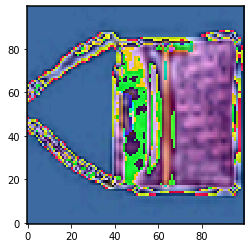

In [78]:
sample, time = dataset[0]
plt.imshow(transforms.ToPILImage()(sample))
plt.show()

In [21]:
# filteredData.to_csv("../fashion/filtered.csv", index=None)